In [1]:
"""
This code belongs to the paper:
-- Y.C. Mathpati, K.S. More, T. Tripura, R. Nayek, S. Chakraborty (2023)
   MAntRA: A framework for model agnostic reliability analysis
   
-- This code is for 3-DOF nonlinear oscillator Diffusion 2.
"""

'\nThis code belongs to the paper:\n-- Y.C. Mathpati, K.S. More, T. Tripura, R. Nayek, S. Chakraborty (2023)\n   MAntRA: A framework for model agnostic reliability analysis\n   \n-- This code is for 3-DOF nonlinear oscillator Diffusion 2.\n'

In [1]:
import numpy as np
np.random.seed(1)

"""
A 3 DOF Duffing system excited by random noise
-----------------------------------------------------------
"""
def _3_DOF_Duffing_sys(x1, x2, x3, x4, x5, x6, T):
    # parameters 
    m1, m2, m3 = 1, 1, 1
    c1, c2, c3 = 2, 2, 2
    k1, k2, k3 = 1000, 2000, 3000
    alpha1, alpha2, alpha3 = 100000, 100000, 100000
    sigma1, sigma2, sigma3 = 1, 1, 1
    
    dt = 0.001
    t = np.arange(0, T+dt, dt)
    Nsamp = 500 # no. of samples in the run
    
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    y6 = []
    xz1 = []
    xz2 = []
    xz3 = []
    xzs11 = []
    xzs22 = []
    xzs33 = []
    np.random.seed(4)
    
    # Simulation Starts Here ::
    # -------------------------------------------------------
    for ensemble in range(Nsamp):
        x0 = np.array([x1, x2, x3, x4, x5, x6])
        x = np.vstack(x0)                                                          # Zero initial condition.
        for n in range(len(t)-1):
            
            dW = np.sqrt(dt)*np.random.randn(3)
            dW2 = dW[0]
            dW4 = dW[1]
            dW6 = dW[2]
            
            a1 = x0[1]
            a2 = -(c1/m1)*x0[1]-(k1/m1)*x0[0]-(c2/m1)*(x0[1]-x0[3])-k2*(x0[0]-x0[2])-(alpha1/m1)*(x0[0])**3-(alpha2/m1)*(x0[0]-x0[2])**3
            a3 = x0[3]
            a4 = -(c2/m2)*(x0[3]-x0[1])-(k2/m2)*(x0[2]-x0[0])-(c3/m2)*(x0[3]-x0[5])-k3/m2*(x0[2]-x0[4])-(alpha2/m2)*(x0[2]-x0[0])**3-(alpha3/m2)*(x0[2]-x0[4])**3
            a5 = x0[5]
            a6 = -(c3/m3)*(x0[5]-x0[3])-(k3/m3)*(x0[4]-x0[2])-(alpha3/m3)*(x0[4]-x0[2])**3
            b2 = (sigma1/m1)
            b4 = (sigma2/m2)
            b6 = (sigma3/m3)

            sol1 = x0[0] + a1*dt 
            sol2 = x0[1] + a2*dt + b2*dW2
            sol3 = x0[2] + a3*dt 
            sol4 = x0[3] + a4*dt + b4*dW4
            sol5 = x0[4] + a5*dt 
            sol6 = x0[5] + a6*dt + b6*dW6
            
            x0 = np.array([sol1, sol2, sol3, sol4, sol5, sol6])
            x = np.column_stack((x, x0))
            
        y1.append(x[0,:])
        y2.append(x[1,:])
        y3.append(x[2,:])
        y4.append(x[3,:])
        y5.append(x[4,:])
        y6.append(x[5,:])
        
        zint1 = x[1,0:-1]
        xfinal1 = x[1,1:] 
        xmz1 = (xfinal1 - zint1) # 'x(t)-z' vector
        
        zint2 = x[3, 0:-1]
        xfinal2 = x[3, 1:] 
        xmz2 = (xfinal2 - zint2) # 'x2(t)-z2' vector
        
        zint3 = x[5, 0:-1]
        xfinal3 = x[5, 1:] 
        xmz3 = (xfinal3 - zint3) # 'x2(t)-z2' vector
        
        xz1.append(xmz1)
        xz2.append(xmz2)
        xz3.append(xmz3)
        
        xmzsq11 = np.multiply(xmz1, xmz1)
        xzs11.append(xmzsq11)
        
        xmzsq22 = np.multiply(xmz2, xmz2)
        xzs22.append(xmzsq22)
        
        xmzsq33 = np.multiply(xmz3, xmz3)
        xzs33.append(xmzsq33)
        
    xz1 = pow(dt,-1)*np.mean(np.array(xz1), axis = 0)
    xz2 = pow(dt,-1)*np.mean(np.array(xz2), axis = 0)
    xz3 = pow(dt,-1)*np.mean(np.array(xz3), axis = 0)
    
    xzs11 = pow(dt,-1)*np.mean(np.array(xzs11), axis = 0)
    xzs22 = pow(dt,-1)*np.mean(np.array(xzs22), axis = 0)
    xzs33 = pow(dt,-1)*np.mean(np.array(xzs33), axis = 0) 
    
    y1 = np.array(y1)
    y2 = np.array(y2)
    y3 = np.array(y3)
    y4 = np.array(y4)
    y5 = np.array(y5)
    y6 = np.array(y6)
    
    time = t[0:-1]
    
    return xz1, xz2, xz3, xzs11, xzs22, xzs33, y1, y2, y3, y4, y5, y6, time

In [2]:
import numpy as np
from scipy import linalg as LA
from sklearn.metrics import mean_squared_error as MSE

"""
The Dictionary creation part:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
def library(xt, polyn, harmonic):
    if polyn == 0:
        polyn = 1
    
    # The polynomial is (x1 + x2)^p, with p is the order
    # poly order 0
    ind = 0
    n = len(xt[0])
    D = np.ones([n,1])
    
    if polyn >= 1:
        # poly order 1
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(xt[i,:])
            D = np.append(D, new, axis=1)
    if polyn >= 2: 
        # ploy order 2
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                ind = ind+1
                new = np.multiply(xt[i,:], xt[j,:])
                new = np.vstack(new)
                D = np.append(D, new, axis=1) 
    if polyn >= 3:    
        # ploy order 3
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    ind = ind+1
                    new = np.multiply(np.multiply(xt[i,:], xt[j,:]), xt[k,:])
                    new = np.vstack(new)
                    D = np.append(D, new, axis=1) 
    if polyn >= 4:
        # ploy order 4
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in range(k,len(xt)):
                        ind = ind+1
                        new = np.multiply(np.multiply(xt[i,:], xt[j,:]), xt[k,:])
                        new = np.multiply(new, xt[l,:])
                        new = np.vstack(new)
                        D = np.append(D, new, axis=1) 
    if polyn >= 5:
        # ploy order 5
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in  range(k,len(xt)):
                        for m in  range(l,len(xt)):
                            ind = ind+1
                            new = np.multiply(xt[i,:], xt[j,:])
                            new = np.multiply(new, xt[k,:])
                            new = np.multiply(new, xt[l,:])
                            new = np.multiply(new, xt[m,:])
                            new = np.vstack(new)
                            D = np.append(D, new, axis=1) 
    if polyn >= 6:
        # ploy order 6
        for i in range(len(xt)):
            for j in  range(i,len(xt)):
                for k in  range(j,len(xt)):
                    for l in  range(k,len(xt)):
                        for m in  range(l,len(xt)):
                            for n in  range(m,len(xt)):
                                ind = ind+1
                                new = np.multiply(xt[i,:], xt[j,:])
                                new = np.multiply(new, xt[k,:])
                                new = np.multiply(new, xt[l,:])
                                new = np.multiply(new, xt[m,:])
                                new = np.multiply(new, xt[n,:])
                                new = np.vstack(new)
                                D = np.append(D, new, axis=1) 
    # for the signum or sign operator
    for i in range(len(xt)):
        ind = ind+1
        new = np.vstack(np.sign(xt[i,:]))+0.0001
        D = np.append(D, new, axis=1)
    
    # for the modulus operator
    for i in range(len(xt)):
        ind = ind+1
        new = np.vstack(abs(xt[i,:]))
        D = np.append(D, new, axis=1)
    # for the tensor operator
    for i in range(len(xt)):
        for j in  range(len(xt)):
            ind = ind+1
            new = np.multiply(xt[i,:],abs(xt[j,:]))
            new = np.vstack(new)
            D = np.append(D, new, axis=1)
    if harmonic == 1:
        # for sin(x)
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(np.sin(xt[i,:]))
            D = np.append(D, new, axis=1)
            #  or,
            # ind = ind+1
            # new = np.sin(xt[i,:])
            # D = np.insert(D, ind, new, axis=1)
        # for cos(x)
        for i in range(len(xt)):
            ind = ind+1
            new = np.vstack(np.cos(xt[i,:]))
            D = np.append(D, new, axis=1)
#     ind = ind+1
    
    # D = D[:, 0:7] 
    ind = len(D[0])
    return D, ind

In [3]:
import numpy as np

T = 1
# Response generation: 
x1, x2, x3, x4, x5, x6 = 0.00001, 0, 0.00001, 0, 0.00001, 0                                # initial displacement for 3dof
xdrift1, xdrift2, xdrift3, xdiff11, xdiff22, xdiff33, y1, y2, y3, y4, y5, y6, t_eval = _3_DOF_Duffing_sys(x1, x2, x3, x4, x5, x6, T)

# Expected Dictionary Creation:
# Expected Dictionary Creation:
libr = []
for j in range(len(y1)):
    data = np.row_stack((y1[j,0:-1], y2[j,0:-1], y3[j,0:-1], y4[j,0:-1], y5[j,0:-1], y6[j,0:-1]))
    Dtemp, nl = library(data, 4, 0)
    libr.append(Dtemp)
libr = np.array(libr)
Dictionary= np.mean(libr, axis = 0)
xdts = xdiff22

In [4]:
D=Dictionary

In [5]:
D.shape

(1000, 258)

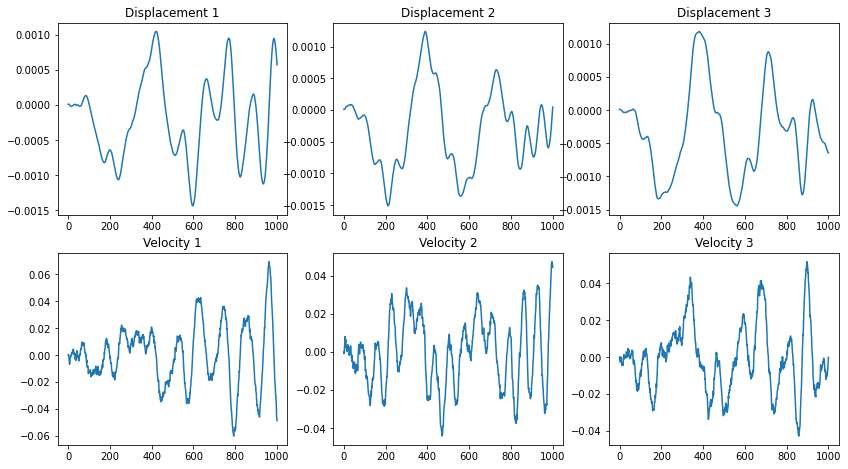

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
plt.subplot(3,3,1)
plt.plot(np.mean((y1), axis=0))
plt.title('Displacement 1')
plt.subplot(3,3,2)
plt.plot(np.mean((y3), axis=0))
plt.title('Displacement 2')
plt.subplot(3,3,3)
plt.plot(np.mean((y5), axis=0))
plt.title('Displacement 3')
plt.subplot(3,3,4)
plt.plot(np.mean((y2), axis=0))
plt.title('Velocity 1')
plt.subplot(3,3,5)
plt.plot(np.mean((y4), axis=0))
plt.title('Velocity 2')
plt.subplot(3,3,6)
plt.plot(np.mean((y6), axis=0))
plt.title('Velocity 3')

plt.show()

In [7]:
Dict = D.reshape(-1,order='F')
Dict.shape

(258000,)

In [8]:
#!/usr/bin/env python
"""
Sample script that uses the SparseBayes module created using
MATLAB Compiler SDK.

Refer to the MATLAB Compiler SDK documentation for more information.
"""

from __future__ import print_function
import SparseBayes
import matlab

my_SparseBayes = SparseBayes.initialize()

DictIn = matlab.double(Dict, size=(D.shape[0], D.shape[1]))
targetIn = matlab.double(xdts, size=(D.shape[0], 1))
DMOut = my_SparseBayes.SparseBayes(DictIn, targetIn)
print(DMOut, sep='\n')

my_SparseBayes.terminate()

{'Relevant': matlab.double([[1.0],[4.0],[9.0],[14.0],[22.0],[23.0],[24.0],[25.0],[26.0],[28.0],[42.0],[44.0],[64.0],[73.0],[85.0],[87.0],[90.0],[103.0],[107.0],[108.0],[122.0],[134.0],[141.0],[147.0],[152.0],[156.0],[176.0],[210.0],[216.0],[221.0],[229.0]]), 'Value': matlab.double([[1.000456750046443],[58.5971056023459],[64.80428090271339],[0.5340828620346918],[-41.363640433216034],[-1.5023156532154662],[-1.8085290682880406],[8.60932632474435],[3230.830276181296],[2.5700479704947],[-105256.73179669642],[44.590694571239304],[-0.08542543200812691],[-142.3843965632333],[17416946.04993008],[-19318224.53420256],[78062.80162962351],[242362.54831728412],[9528.782480820195],[39.59357656344687],[31069.312534636712],[-92445.44318529715],[0.09033398024468824],[27.025041891780646],[-1.8730574487122402],[35364.02349578411],[2216985.493399953],[0.7449515844969802],[0.10700535173725954],[-14.524860076637292],[50.17731771152181]])}


In [9]:
c = np.array(DMOut['Value'])
d = []
for j in c:
    d.append(j[0])
    
d

[1.000456750046443,
 58.5971056023459,
 64.80428090271339,
 0.5340828620346918,
 -41.363640433216034,
 -1.5023156532154662,
 -1.8085290682880406,
 8.60932632474435,
 3230.830276181296,
 2.5700479704947,
 -105256.73179669642,
 44.590694571239304,
 -0.08542543200812691,
 -142.3843965632333,
 17416946.04993008,
 -19318224.53420256,
 78062.80162962351,
 242362.54831728412,
 9528.782480820195,
 39.59357656344687,
 31069.312534636712,
 -92445.44318529715,
 0.09033398024468824,
 27.025041891780646,
 -1.8730574487122402,
 35364.02349578411,
 2216985.493399953,
 0.7449515844969802,
 0.10700535173725954,
 -14.524860076637292,
 50.17731771152181]

In [10]:
a = np.array(DMOut['Relevant'])
b = []
for i in a:
    b.append(int((i[0])-1))
    
b

[0,
 3,
 8,
 13,
 21,
 22,
 23,
 24,
 25,
 27,
 41,
 43,
 63,
 72,
 84,
 86,
 89,
 102,
 106,
 107,
 121,
 133,
 140,
 146,
 151,
 155,
 175,
 209,
 215,
 220,
 228]

In [11]:
initz0_1 = np.zeros(D.shape[1])
for i in b:
    initz0_1[i] = 1
    
initz0_1

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [12]:
import warnings
import math
import numpy as np
import scipy as sp
import sympy as smp
from scipy import stats
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy.random import gamma
from scipy.special import loggamma

def Variational_Bayes_Code(X, y, initz0, tol, verbosity):

    if (len(X) == 0 or len(y) == 0):
        raise Exception('X and or y is missing')
        
    if (len(X) != len(y)):
        raise Exception('Number of observations do not match')
        
    # X = stats.zscore(X, ddof = 1)         
    # X = np.c_[np.ones(len(X)),X]
    # X = np.c_[np.ones(len(X)),X]          
    # y = y - np.mean(y)
    N = len(X)
    # Prior parameters of noise variance (Inverse Gamma dist)
    A = 1e-4
    B = 1e-4
    vs = 10
    tau0 = 1000
    
    if (len(initz0) == 0):
        raise Exception('No initial value of z found')
    else:
        p0 = expit(-0.5*(np.sqrt(N)))       
        
        # Adding the intercept indicator variable (slightly less than 1 to prevent log(0) values) 
        # initz = np.hstack((1,initz0))  
        initz = initz0

        DS,LLcvg  = run_VB2(X, y, vs, A, B, tau0, p0, initz, tol, verbosity)    
        # This is function which will come first
        
    out_vb   = DS
    a = DS['zmean'] > 0.5
    count = 0
    modelIdx = []
    for i in a:
        if i == True:
            modelIdx.append(count)
        count += 1
            
    modelIdx = np.setdiff1d(modelIdx,0)
    out_vb['modelIdx'] = modelIdx-1
    out_vb['Zmed'] = DS['zmean'][modelIdx]
    out_vb['Wsel'] = DS['wmean'][modelIdx]
    out_vb['Wcov'] = DS['wCOV'][modelIdx, modelIdx]
    out_vb['sig2'] = DS['sig2']
    
    return out_vb

DS = {}
def run_VB2(Xc, yc, vs, A, B, tau0, p0, initz, tol, verbosity):
    """This function is the implementation of VB from John T. Ormerod paper (2014)
       This implementation uses slab scaling by noise variance
       vs    : treated as a constant
       A,B   : constants of the IG prior over noise variance
       tau0  : Expected value of (sigma^{-2})
       p0    : inclusion probablility
       initz : Initial value of z
       Xc    : Centered and standardized dictionary except the first column
       yc    : Centered observations """
    
    Lambda    = logit(p0)
    iter_     = 0
    max_iter  = 100
    LL        = np.zeros(max_iter)        
    zm        = np.reshape(initz,(-1))            
    taum      = tau0                      
    invVs     = 1/vs
    
    X = Xc
    y = yc
    XtX = (X.T) @ X
    XtX = 0.5*(XtX + (XtX).T)
    Xty = (X.T) @ y                 
    yty = (y.T) @ y

    eyep = np.eye(len(XtX))
    [N,p] = X.shape
    allidx = np.arange(p)
    zm[0] = 1                                                                   # Always include the intercept 
    Abar    = (A + 0.5*N + 0.5*p)
    converged = 0
    
    while (converged==0):
        if (iter_==100):
            break
        
        Zm       = np.diag(zm)
        Omg      = (np.reshape(zm,(-1,1)) @ np.reshape(zm,(1,-1))) + (Zm @ (eyep-Zm))
        # Update the mean and covariance of the coefficients given mean of z
        term1    = XtX * Omg                                                       # elementwisw multiplication
        invSigma = taum * (term1 + invVs * eyep)
        invSigma = 0.5*(invSigma + invSigma.T)                                     # symmetric
        Sigma    = la.inv(invSigma) @ eyep
        mu       = taum * (Sigma @ Zm @ Xty)                                       # @ ---> matrix multiplication
        
        # Update tau related to sigma
        term2    = 2 * Xty @ Zm @ mu
        term3    =  np.reshape(mu,(len(initz0),1)) @ np.reshape(mu,(1,len(initz0)))+ Sigma
        term4    = yty - term2 + np.trace((term1 + invVs * eyep) @ term3)    
        s        = B + 0.5*term4
        
        if s<0:
            warnings.warn('s turned out be less than 0. Taking absolute value')
            s = B + 0.5*abs(term4)
        
        taum     = Abar / s
        zstr   = zm

        order   = np.setdiff1d(np.random.permutation(p), 0, assume_unique=True)
        for j in order: 
            muj     = mu[j]                            
            sigmaj  = Sigma[j,j]
            
            remidx  = np.setdiff1d(allidx,j)
            mu_j    = mu[remidx]
            Sigma_jj= Sigma[remidx,j]
            etaj    = (Lambda - 0.5 * taum * ((muj**2 + sigmaj) * XtX[j,j]) 
                       + taum * np.reshape(X[:,j],(1,-1)) @ (np.reshape(y,(-1,1))*muj 
                        -X[:,remidx] @ np.diag(zstr[remidx]) @ ((mu_j * muj + Sigma_jj).reshape(-1,1))))
            zstr[j] = expit(etaj)
            
        zm = zstr
        
        # Calculate marginal log-likelihood
        
        LL[iter_] = ( 0.5*p 
                    - 0.5*N*np.log(2*np.pi) 
                    + 0.5*p*np.log(invVs) 
                    + A*np.log(B)
                    - loggamma(A)
                    + loggamma(Abar) 
                    - Abar*np.log(s)
                    + 0.5*np.log(la.det(Sigma))
                    + np.nansum(zm*(np.log(p0) - np.log(zm))) 
                    + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
        
        if(verbosity):
            print(f'Iteration = {iter_}  log(Likelihood) = {LL[iter_]}')
        
        if(iter_>1):
            cvg = LL[iter_] - LL[iter_-1]
            
            if (cvg < 0 and verbosity):
                print('OOPS!  log(like) decreasing!!')
            elif (cvg<tol or iter_> max_iter):
                converged = 1
                LL = LL[0:iter_]
                
        iter_    = iter_ + 1
    DS['zmean'] = zm
    DS['wmean'] = mu
    DS['wCOV'] = Sigma
    DS['sig2'] = 1/taum
    LLcvg    = LL[-1]
    return DS, LLcvg
    
def logit(C):
    logitC = np.log(C) - np.log(1-C)
    return logitC

def expit(C):
    expitC = 1./(1 + np.exp(-C))
    return expitC

In [13]:
tol = 0.0001
verbosity = True
initz0 = initz0_1
DS = Variational_Bayes_Code(D, xdts, initz0, tol, verbosity)

print(DS) 

C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:145: RuntimeWarning: divide by zero encountered in log
  + 0.5*np.log(la.det(Sigma))
C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:147: RuntimeWarning: divide by zero encountered in log
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:147: RuntimeWarning: invalid value encountered in multiply
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))


Iteration = 0  log(Likelihood) = -inf


C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:174: RuntimeWarning: overflow encountered in exp
  expitC = 1./(1 + np.exp(-C))
C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:146: RuntimeWarning: divide by zero encountered in log
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
C:\Users\USER\AppData\Local\Temp/ipykernel_12828/3512855728.py:146: RuntimeWarning: invalid value encountered in multiply
  + np.nansum(zm*(np.log(p0) - np.log(zm)))


Iteration = 1  log(Likelihood) = -80.52515505893953
Iteration = 2  log(Likelihood) = -78.13085092413655
Iteration = 3  log(Likelihood) = -78.04392875503514
Iteration = 4  log(Likelihood) = -78.04037307054956
Iteration = 5  log(Likelihood) = -78.04022434996288
Iteration = 6  log(Likelihood) = -78.0402181010909
{'zmean': array([1.00000000e+000, 1.35634745e-007, 1.08801266e-008, 1.35563010e-007,
       2.49408746e-008, 1.35506782e-007, 2.42666068e-008, 1.35856344e-007,
       1.35802534e-007, 1.35861673e-007, 1.35768276e-007, 1.35856409e-007,
       1.35714503e-007, 1.00000000e+000, 1.35689150e-007, 3.76053648e-027,
       1.35752715e-007, 6.96299998e-014, 1.35796952e-007, 1.35623437e-007,
       1.35816883e-007, 1.35660318e-007, 1.00000000e+000, 1.35513670e-007,
       2.97088653e-048, 1.35758434e-007, 1.35623473e-007, 1.00000000e+000,
       1.35894303e-007, 1.35894232e-007, 1.35894303e-007, 1.35894245e-007,
       1.35894303e-007, 1.35894204e-007, 1.35796207e-007, 1.35894250e-007,
    

In [16]:
mut1 = DS['wmean']
sigt = DS['wCOV']
DS['zmean'][np.where(DS['zmean']<0.5)] = 0
mut1[np.where(DS['zmean']<0.5)] = 0
DS['zmean'][np.where(np.diag(sigt)>0.005)] = 0
mut1[np.where(np.diag(sigt)>0.05)] = 0
DS['wmean'][np.where(DS['zmean']==0)] = 0

<StemContainer object of 3 artists>

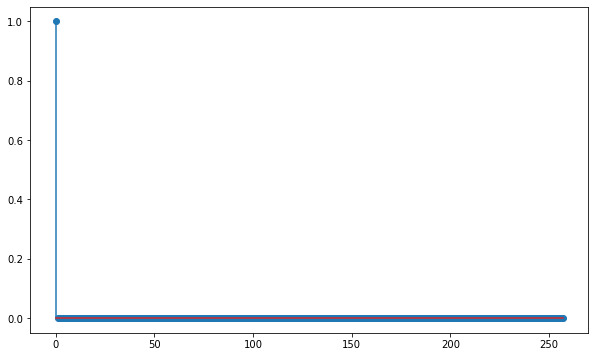

In [17]:
plt.figure(figsize=(10,6))
plt.stem(DS['zmean'])

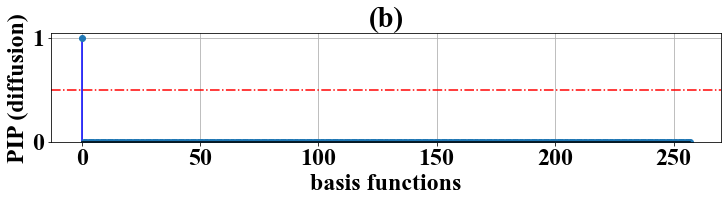

In [18]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 2))
xr = np.array(range(nl))
plt.stem(xr,DS['zmean'], use_line_collection = True, linefmt='blue', basefmt="k")
plt.axhline(y= 0.5, color='r', linestyle='-.')
plt.title('(b)', fontweight='bold')
plt.xlabel('basis functions',fontweight='bold')
plt.ylabel('PIP (diffusion)', fontweight='bold');
plt.grid(True); plt.ylim(0,1.05)
plt.xticks(fontweight='bold'); plt.yticks(fontweight='bold');
figure1.savefig('3dof_diff2.png',format='png',dpi=600,bbox_inches='tight')

In [19]:
np.sqrt(DS['wmean'])

array([0.99310203, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [20]:
np.sqrt(DS['wmean'])

array([0.99310203, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     